<a href="https://colab.research.google.com/github/dingyida/reinforce-learning/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [23]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 1000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [25]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [26]:
def epsilon_greedy(state, epsilon):
    """ε-greedy action selection using the current q_net."""
    if random.random() < epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        s = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q = q_net(s)  # [1, n_actions]
        return int(torch.argmax(q, dim=1).item())


In [27]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[Ep   50] Return=-391.00  Avg(50)=-8574.18  ε=0.778  Buffer=50000
[Ep  100] Return=-331.00  Avg(50)=-512.28  ε=0.606  Buffer=50000
[Ep  150] Return=-207.00  Avg(50)=-281.22  ε=0.471  Buffer=50000
[Ep  200] Return=-154.00  Avg(50)=-226.92  ε=0.367  Buffer=50000
[Ep  250] Return=-143.00  Avg(50)=-190.42  ε=0.286  Buffer=50000
[Ep  300] Return=-139.00  Avg(50)=-169.10  ε=0.222  Buffer=50000
[Ep  350] Return=-147.00  Avg(50)=-163.34  ε=0.173  Buffer=50000
[Ep  400] Return=-160.00  Avg(50)=-155.76  ε=0.135  Buffer=50000
[Ep  450] Return=-125.00  Avg(50)=-158.12  ε=0.105  Buffer=50000
[Ep  500] Return=-143.00  Avg(50)=-162.22  ε=0.082  Buffer=50000
[Ep  550] Return=-146.00  Avg(50)=-156.10  ε=0.063  Buffer=50000
[Ep  600] Return=-185.00  Avg(50)=-137.70  ε=0.049  Buffer=50000
[Ep  650] Return=-115.00  Avg(50)=-137.20  ε=0.038  Buffer=50000
[Ep  700] Return=-106.00  Avg(50)=-127.36  ε=0.030  Buffer=50000
[Ep  750] Return=-110.00  Avg(50)=-116.00  ε=0.023  Buffer=50000
[Ep  800] Return=-127.00

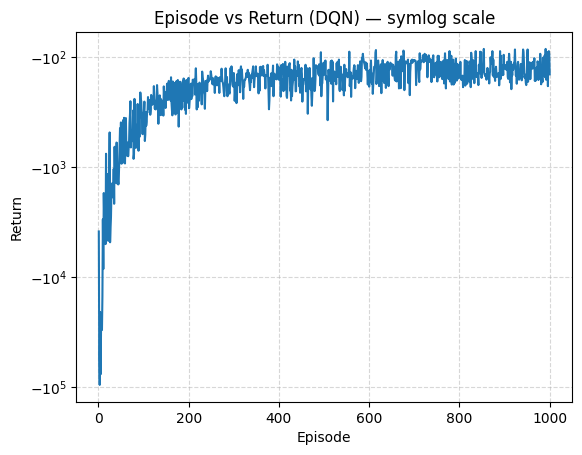

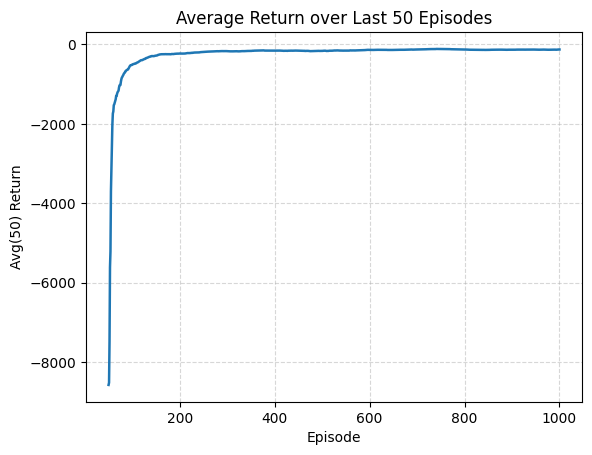

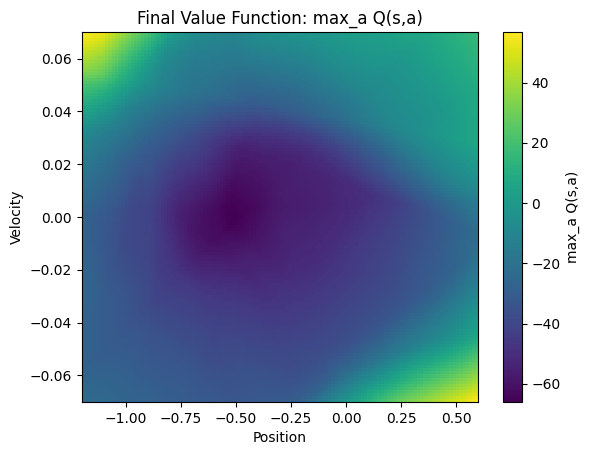

In [28]:
## MAIN Loop ###
rewards_dqn = []

for episode in range(num_episodes):
  state = env.reset()[0]
  total_reward = 0
  done = False

  while not done:
    action = epsilon_greedy(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)

    replay_buffer.append((state, action, reward, next_state, float(done)))


    train_dqn()


    state = next_state
    total_reward += reward

    if done:
        break

    # Epsilon decay per episode
  epsilon = max(epsilon_min, epsilon * epsilon_decay)

  rewards_dqn.append(total_reward)

    # (Optional) lightweight logging
  if (episode + 1) % 50 == 0:
      avg50 = np.mean(rewards_dqn[-50:]) if len(rewards_dqn) >= 50 else np.mean(rewards_dqn)
      print(f"[Ep {episode+1:4d}] Return={total_reward:7.2f}  Avg(50)={avg50:7.2f}  ε={epsilon:5.3f}  Buffer={len(replay_buffer)}")



# =========================
# POST-TRAINING PLOTS
# =========================
import matplotlib.pyplot as plt
import numpy as np

episodes_axis = np.arange(1, len(rewards_dqn) + 1)

# ---- (1) Episode vs Return (log scale) ----
plt.figure()
plt.plot(episodes_axis, rewards_dqn, linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Episode vs Return (DQN) — symlog scale")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
# Use symmetric log so negative rewards are supported (MountainCar returns are often negative)
plt.yscale("symlog", linthresh=1.0)

# ---- (2) Avg(50) Reward ----
window = 50
if len(rewards_dqn) >= window:
    # moving average (valid part only)
    kernel = np.ones(window, dtype=float) / window
    avg50 = np.convolve(rewards_dqn, kernel, mode="valid")
    episodes_avg = np.arange(window, len(rewards_dqn) + 1)
else:
    # not enough points yet; show a simple running mean
    avg50 = np.array([np.mean(rewards_dqn[:i]) for i in range(1, len(rewards_dqn) + 1)])
    episodes_avg = episodes_axis

plt.figure()
plt.plot(episodes_avg, avg50, linewidth=1.8)
plt.xlabel("Episode")
plt.ylabel("Avg(50) Return")
plt.title("Average Return over Last 50 Episodes")
plt.grid(True, linestyle="--", alpha=0.5)

# ---- (3) Final Value Function: max_a Q(s,a) over state grid ----
# MountainCar state bounds
pos_low, vel_low = env.observation_space.low
pos_high, vel_high = env.observation_space.high

# Build a grid over (position, velocity)
N_pos, N_vel = 121, 121   # resolution (adjust if you want finer/coarser)
pos_grid = np.linspace(pos_low, pos_high, N_pos)
vel_grid = np.linspace(vel_low, vel_high, N_vel)
P, V = np.meshgrid(pos_grid, vel_grid)  # shapes [N_vel, N_pos]

grid_states = np.stack([P.ravel(), V.ravel()], axis=1)  # [N_pos*N_vel, 2]

# Evaluate max Q on the grid
q_net.eval()
with torch.no_grad():
    s = torch.tensor(grid_states, dtype=torch.float32, device=device)
    q = q_net(s)                                # [N_pos*N_vel, n_actions]
    max_q = q.max(dim=1).values.detach().cpu().numpy()  # [N_pos*N_vel]

Z = max_q.reshape(N_vel, N_pos)  # reshape to match meshgrid (rows=vel, cols=pos)

plt.figure()
im = plt.imshow(
    Z,
    origin="lower",
    extent=[pos_low, pos_high, vel_low, vel_high],
    aspect="auto"
)
plt.colorbar(im, label="max_a Q(s,a)")
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.title("Final Value Function: max_a Q(s,a)")

plt.show()


# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?
